In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
#making matrices
m = 64
n = m * m  

e0 = np.zeros((n, 1))  
e1 = np.ones((n, 1))   
e2 = np.copy(e1)   
e4 = np.copy(e0)   

for j in range(1, m+1):
    e2[m*j-1] = 0  
    e4[m*j-1] = 1  


e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]


diagonals = [e1.flatten(), e1.flatten(), e5.flatten(), 
             e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]

A1 = spdiags(diagonals, offsets, n, n).toarray()

e1 = np.ones((n, 1))

diagonals = [e1.flatten(), -1*e1.flatten(), e1.flatten(), -1*e1.flatten()]
offsets = [-(n-m), -m, m, (n-m)]

B1 = spdiags(diagonals, offsets, n, n).toarray()

e0 = np.zeros((n, 1))  
e1 = np.ones((n, 1))   
e2 = np.copy(e1)    
e4 = np.copy(e0)   

for j in range(1, m+1):
    e2[m*j-1] = 0  
    e4[m*j-1] = 1  

e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

diagonals = [e5.flatten(), -e2.flatten(), e3.flatten(), -e4.flatten()]
offsets = [-m+1, -1, 1, m-1]

C1 = spdiags(diagonals, offsets, n, n).toarray()

delta=(20/64)
A=(1/delta**2)*A1
B=(1/(2*delta))*B1
C=(1/(2*delta))*C1

In [12]:
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp
import time

#setting up the space

tspan = np.arange(0,30,1)
nx, ny=64, 64
nu=0.001
N = nx*ny
x2=np.linspace(-50,50,nx+1)
x=x2[:nx]
y2=np.linspace(-50,50,ny+1)
y=y2[:ny]
X, Y = np.meshgrid(x,y)

kx = (2 * np.pi / 100) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = (2 * np.pi / 100) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
kx[0], ky[0]=1e-6, 1e-6
KX, KY = np.meshgrid(kx,ky)
K = (KX**2)+(KY**2)

Elapsed time: 3.53 seconds
(4096, 9)


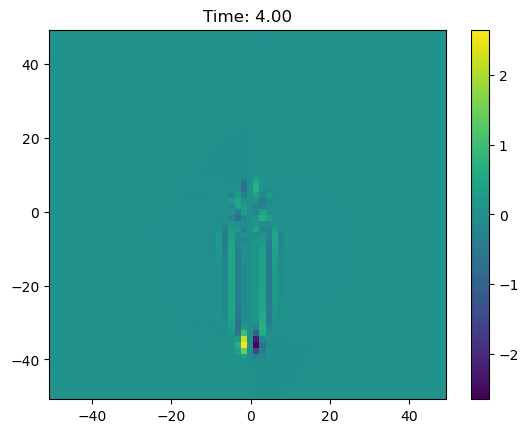

In [23]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
tspan = np.arange(0,4.5,0.5)
a1 = 5          
a2 = -5         
x1, y1 = -1, 0   
x2, y2 = 1, 0     
sigma = 0.5       

w = (
    a1 * np.exp(-((X - x1)**2 + (Y - y1)**2) / (2 * sigma**2)) +
    a2 * np.exp(-((X - x2)**2 + (Y - y2)**2) / (2 * sigma**2))
)


start_time = time.time()

def solver(t, w0, nx, ny, N, A, B, C):
    wt0 = fft2(w0.reshape((nx,ny)))
    psit = -wt0 / K 
    psi = np.real(ifft2(psit)).reshape(N) 
    dw = nu*np.dot(A,w0) 
    psi_dx = np.dot(B,psi) 
    psi_dy = np.dot(C, psi)
    w_dx = np.dot(B,w0) 
    w_dy = np.dot(C,w0)
    rhs = dw-(psi_dx*w_dy)+(psi_dy*w_dx) 
    return rhs.reshape(N)

w0 = w.reshape(N)
wsol = solve_ivp(solver, [0,5], w0, args = (nx, ny, N, A, B, C), t_eval = tspan)
  
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

print(wsol.y.shape)

def get_frame(j):
    return wsol.y[:, j].reshape((nx, ny))


fig, ax = plt.subplots()
pcolor = ax.pcolor(X, Y, get_frame(0), shading='auto', cmap='viridis')
cbar = plt.colorbar(pcolor, ax=ax)
title = ax.set_title(f'Time: {tspan[0]:.2f}')


def update(frame):
    w = get_frame(frame)
    pcolor.set_array(w.ravel())  
    title.set_text(f'Time: {tspan[frame]:.2f}')
    return pcolor, title


ani = FuncAnimation(
    fig, update, frames=len(tspan), interval=300, blit=True
)


HTML(ani.to_jshtml())

Elapsed time: 17.32 seconds


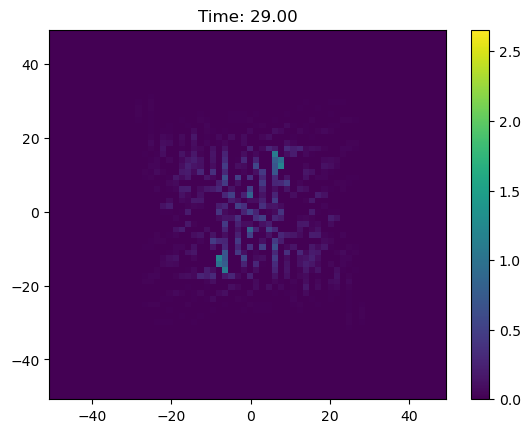

In [21]:
a = 5
w = (
    a * np.exp(-((X - x1)**2 + (Y - y1)**2) / (2 * sigma**2)) +
    a * np.exp(-((X - x2)**2 + (Y - y2)**2) / (2 * sigma**2))
)

tspan = np.arange(0,30,1)

start_time = time.time()

def solver(t, w0, nx, ny, N, A, B, C):
    wt0 = fft2(w0.reshape((nx,ny)))
    psit = -wt0 / K 
    psi = np.real(ifft2(psit)).reshape(N) 
    dw = nu*np.dot(A,w0) 
    psi_dx = np.dot(B,psi) 
    psi_dy = np.dot(C, psi)
    w_dx = np.dot(B,w0) 
    w_dy = np.dot(C,w0)
    rhs = dw-(psi_dx*w_dy)+(psi_dy*w_dx) 
    return rhs.reshape(N)

w0 = w.reshape(N)
wsol = solve_ivp(solver, [0,30], w0, args = (nx, ny, N, A, B, C), t_eval = tspan)
  
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

fig, ax = plt.subplots()
pcolor = ax.pcolor(X, Y, get_frame(0), shading='auto', cmap='viridis')
cbar = plt.colorbar(pcolor, ax=ax)
title = ax.set_title(f'Time: {tspan[0]:.2f}')

ani = FuncAnimation(
    fig, update, frames=len(tspan), interval=300, blit=True
)


HTML(ani.to_jshtml())

Elapsed time: 1.86 seconds


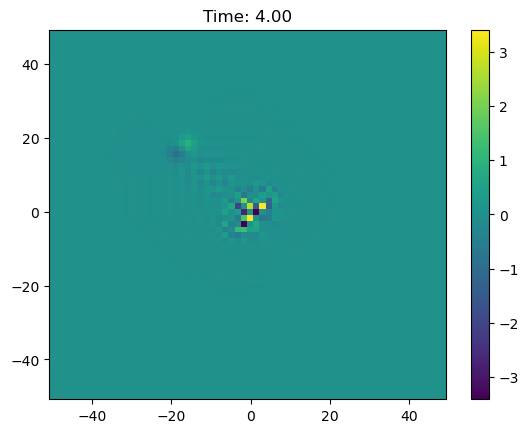

In [54]:
x1, y1 = 0, 2
x2, y2 = 0, -2
x3, y3 = -2, 0
x4, y4 = 2, 0

w = (
    a1 * np.exp(-((X - x1)**2 + (Y - y1)**2) / (2 * sigma**2)) -
    a1 * np.exp(-((X - x2)**2 + (Y - y2)**2) / (2 * sigma**2)) +
    a2 * np.exp(-((X - x3)**2 + (Y - y3)**2) / (2 * sigma**2)) -
    a2 * np.exp(-((X - x4)**2 + (Y - y4)**2) / (2 * sigma**2))
)


start_time = time.time()
tspan = np.arange(0,4.5,0.5)

def solver(t, w0, nx, ny, N, A, B, C):
    wt0 = fft2(w0.reshape((nx,ny)))
    psit = -wt0 / K 
    psi = np.real(ifft2(psit)).reshape(N) 
    dw = nu*np.dot(A,w0) 
    psi_dx = np.dot(B,psi) 
    psi_dy = np.dot(C, psi)
    w_dx = np.dot(B,w0) 
    w_dy = np.dot(C,w0)
    rhs = dw-(psi_dx*w_dy)+(psi_dy*w_dx) 
    return rhs.reshape(N)

w0 = w.reshape(N)
wsol = solve_ivp(solver, [0,4], w0, args = (nx, ny, N, A, B, C), t_eval = tspan)
  
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")



fig, ax = plt.subplots()
pcolor = ax.pcolor(X, Y, get_frame(0), shading='auto', cmap='viridis')
cbar = plt.colorbar(pcolor, ax=ax)
title = ax.set_title(f'Time: {tspan[0]:.2f}')
ani = FuncAnimation(
    fig, update, frames=len(tspan), interval=300, blit=True
)


HTML(ani.to_jshtml())

Elapsed time: 12.85 seconds


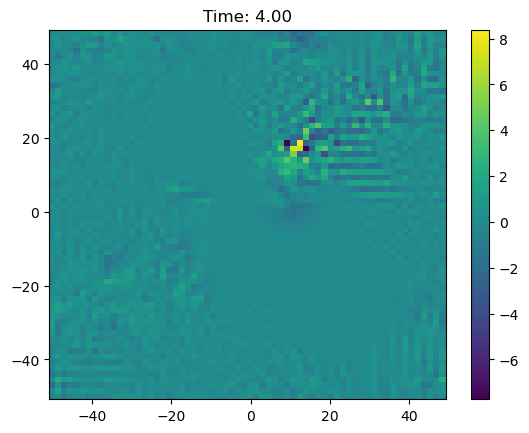

In [56]:
N_vortices = 12
w = np.zeros_like(X)


np.random.seed(42)  
for i in range(N_vortices):
    A = np.random.uniform(-10, 10) 
    x_center = np.random.uniform(-50, 50)  
    y_center = np.random.uniform(-50, 50)  
    sigma_x = np.random.uniform(0.5, 1.5)  
    sigma_y = np.random.uniform(0.5, 1.5)  
    w += A * np.exp(-((X-x_center)**2) / (2 * sigma_x**2) - ((Y-y_center)**2) / (2 * sigma_y**2))
    
    

start_time = time.time()

def solver(t, w0, nx, ny, N, A, B, C):
    wt0 = fft2(w0.reshape((nx,ny)))
    psit = -wt0 / K 
    psi = np.real(ifft2(psit)).reshape(N) 
    dw = nu*np.dot(A,w0) 
    psi_dx = np.dot(B,psi) 
    psi_dy = np.dot(C, psi)
    w_dx = np.dot(B,w0) 
    w_dy = np.dot(C,w0)
    rhs = dw-(psi_dx*w_dy)+(psi_dy*w_dx) 
    return rhs.reshape(N)

w0 = w.reshape(N)
wsol = solve_ivp(solver, [0,4], w0, args = (nx, ny, N, A, B, C), t_eval = tspan)
  
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

fig, ax = plt.subplots()
pcolor = ax.pcolor(X, Y, get_frame(0), shading='auto', cmap='viridis')
cbar = plt.colorbar(pcolor, ax=ax)
title = ax.set_title(f'Time: {tspan[0]:.2f}')
ani = FuncAnimation(
    fig, update, frames=len(tspan), interval=300, blit=True
)


HTML(ani.to_jshtml())